# Subnetwork Analysis, By Genotype

In [2]:
# 0. Import
import os
import sys

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import networkx as nx

from scipy.io import mmread
from scipy.sparse import csr_matrix

In [3]:
import warnings
warnings.filterwarnings('ignore')
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

which: no R in (/apps/software/standard/core/jupyterlab/3.6.3-py3.11:/apps/software/standard/core/jupyterlab/3.6.3-py3.11/sbin:/apps/software/standard/core/jupyterlab/3.6.3-py3.11/bin:/home/apc5un/bedtools2/bin:/sfs/applications/202412_build/software/standard/core/miniforge/24.3.0-py3.11/bin:/opt/mam/9.1.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/slurm/current/bin:/opt/rci/bin:/share/resources/HPCtools:/opt/mam/current/bin:/opt/apptainer/current/bin)


'0.14.0'

In [4]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [5]:
def remove_and_filter(links_df, genes_to_remove, num_edges):
    for g in genes_to_remove:
        links_df = links_df.drop(links_df[links_df.source==g].index)
        links_df = links_df.drop(links_df[links_df.target==g].index)
        
    return links_df.sort_values('coef_abs', ascending=False).iloc[:num_edges]

In [6]:
# Cluster 2 is RA
# Cluster 3 is precursor
# Cluster 4 is LA

thresh_num = 12000

links_wt = co.load_hdf5(file_path="./data/genotype_2500402/wtlinks_alpha1000.celloracle.links")
links_het = co.load_hdf5(file_path="./data/genotype_2500402/hetlinks_alpha1000.celloracle.links")
links_ko = co.load_hdf5(file_path="./data/genotype_2500402/homlinks_alpha1000.celloracle.links")

links_wt.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num)
links_het.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num)
links_ko.filter_links(p=0.001, weight="coef_abs", threshold_number=thresh_num+1000)

links_ko.filtered_links['CMs'] = remove_and_filter(links_ko.filtered_links['CMs'], ['TBX5'], thresh_num)
# links_ko.filtered_links['3'] = remove_and_filter(links_ko.filtered_links['3'], ['TBX5'], thresh_num)
# links_ko.filtered_links['4'] = remove_and_filter(links_ko.filtered_links['4'], ['TBX5'], thresh_num)

links_wt.get_network_score()
links_het.get_network_score()
links_ko.get_network_score()

In [11]:
links_wt.filtered_links['CMs'].to_csv(f"./data/genotype_2500402/wt_{thresh_num}.csv", index=False)
links_het.filtered_links['CMs'].to_csv(f"./data/genotype_2500402/het_{thresh_num}.csv", index=False)
links_ko.filtered_links['CMs'].to_csv(f"./data/genotype_2500402/ko_{thresh_num}.csv", index=False)

# Figure 4G – Plot the 

Higher quality version of these subnetworks can be made using the `visualize-pyvis.py` script.

This is the `plot_subnetwork()` function. It will return a `networkx` network for visualization.

In [8]:
def plot_subnetwork(network, tf_genes, targets):
    graph_df = {'source': [],
                 'target': [],
                 'weight': [],
                 'edge_cols': []}
    
    for curr_gene in tf_genes:
        curr_gene_df = network[network['source'] == curr_gene]
        gene_df_targs = curr_gene_df[curr_gene_df['target'].isin(targets)]

        for index, row in gene_df_targs.iterrows():
            graph_df['source'].append(row['source'])
            graph_df['target'].append(row['target'])
            graph_df['weight'].append(row['coef_mean'])
            if row['coef_mean'] > 0:
                graph_df['edge_cols'].append('green')
            else:
                graph_df['edge_cols'].append('red')

    graph_df = pd.DataFrame(graph_df)

    G = nx.from_pandas_edgelist(graph_df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
    
    from pyvis.network import Network
    net = Network(notebook=True, directed=True)
    # net.force_atlas_2based(gravity=-40, central_gravity=0.005, spring_length=80, spring_strength=0.05, damping=0.8)
    net.force_atlas_2based(gravity=-10, spring_length=40)

    net.from_nx(G)

    for edge in net.edges:
        if edge['width'] > 0:
            edge['color'] = 'grey'
            edge['arrowStrikethrough'] = False
        else:
            edge['color'] = 'red'
            edge['arrows'] = {"to": {"enabled": True, "type": "bar", "scaleFactor":.4}}

        edge['value'] = np.abs(edge['width'])
        edge['width'] = np.abs(edge['width'])


    print(len(net.edges))

    for node in net.nodes:
        if node['id'] in tf_genes:
            node['shape'] = 'diamond'
            node['color'] = 'grey'
            node['size'] = 10
            node['font'] = {'size': 20, 'color': 'black'}
        else:
            node['color'] = 'grey' # Black is neither
            node['font'] = {'size': 1, 'color': 'black'}
            node['size'] = 2
        

    G_act = nx.from_pandas_edgelist(graph_df[graph_df.weight > 0], source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
    G_inact = nx.from_pandas_edgelist(graph_df[graph_df.weight < 0], source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
            
    return net, G_act, G_inact

In [9]:
# FOR WT
links = links_wt.filtered_links['CMs']

# FOR HET
links = links_het.filtered_links['CMs']

# FOR KO
links = links_ko.filtered_links['CMs']

genes_for_subnetwork = ['TBX5', 'NR2F2', 'MEF2C', 'NKX2-5', 'MEIS2', 'GATA4', 'HAND1', 'IRX4', 'HEY2', 'PLAGL1', 
                        'NR2F1', 'HES4', 'E2F1', 'HEY1', 'TCF21', 'TEAD1', 'TCF12']
c = []
c = [c + list(links[links.source == curr_tf].target.values) for curr_tf in genes_for_subnetwork]
targets = [item for sublist in c for item in sublist]

In [10]:
net, G_act, G_inact = plot_subnetwork(links, genes_for_subnetwork, targets)
net.show('net.html')

2314
net.html


# Figure 4H – Visualize a subnetwork for top AF / CHD genes

In [13]:
priority_genes = pd.read_excel("data/genes_for_subnetwork-250316.xlsx", sheet_name=0).values
genes_for_subnetwork = list(priority_genes[:, 1])

In [14]:
# For WT
net, G_act, G_inact = plot_subnetwork(links_wt.filtered_links['CMs'], genes_for_subnetwork, genes_for_subnetwork)

# For HET
net, G_act, G_inact = plot_subnetwork(links_het.filtered_links['CMs'], genes_for_subnetwork, genes_for_subnetwork)

# For KO
net, G_act, G_inact = plot_subnetwork(links_ko.filtered_links['CMs'], genes_for_subnetwork, genes_for_subnetwork)

net.show('net.html')

95
90
61
net.html


# Figure 4I and J – Centrality

In [22]:
cluster = 'CMs'

In [23]:
def get_top_tfs(centrality_set, genes_of_interest, centrality_type):
    # Create a DataFrame with all genes_of_interest initialized to 0
    result_df = pd.DataFrame({centrality_type: 0}, index=genes_of_interest)
    
    # Update the DataFrame with the values from centrality_set
    result_df.update(centrality_set)

    return result_df    

In [30]:
links_wt.get_network_score()
links_het.get_network_score()
links_ko.get_network_score()

In [35]:
# Switch between betweenness_centrality and degree_out here
centrality_type = 'betweenness_centrality'
# centrality_type = 'degree_out'

genes_of_interest = ['TBX5', 'HEY2', 'HAND1', 'E2F1', 'HES4', 'NR2F2', 'HEY1', 'NR2F1', 'PLAGL1', 'TCF12', 'TCF21']

wt_centrality = links_wt.merged_score[links_wt.merged_score.cluster == cluster][centrality_type]
wt_values = get_top_tfs(wt_centrality, genes_of_interest, centrality_type)

het_centrality = links_het.merged_score[links_het.merged_score.cluster == cluster][centrality_type]
het_values = get_top_tfs(het_centrality, genes_of_interest, centrality_type)

ko_centrality = links_ko.merged_score[links_ko.merged_score.cluster == cluster][centrality_type]
ko_values = get_top_tfs(ko_centrality, genes_of_interest, centrality_type)

In [36]:
combined = pd.concat([wt_values[centrality_type], het_values[centrality_type], ko_values[centrality_type]], axis=1)
combined.columns = ['WT', 'Het', 'KO']

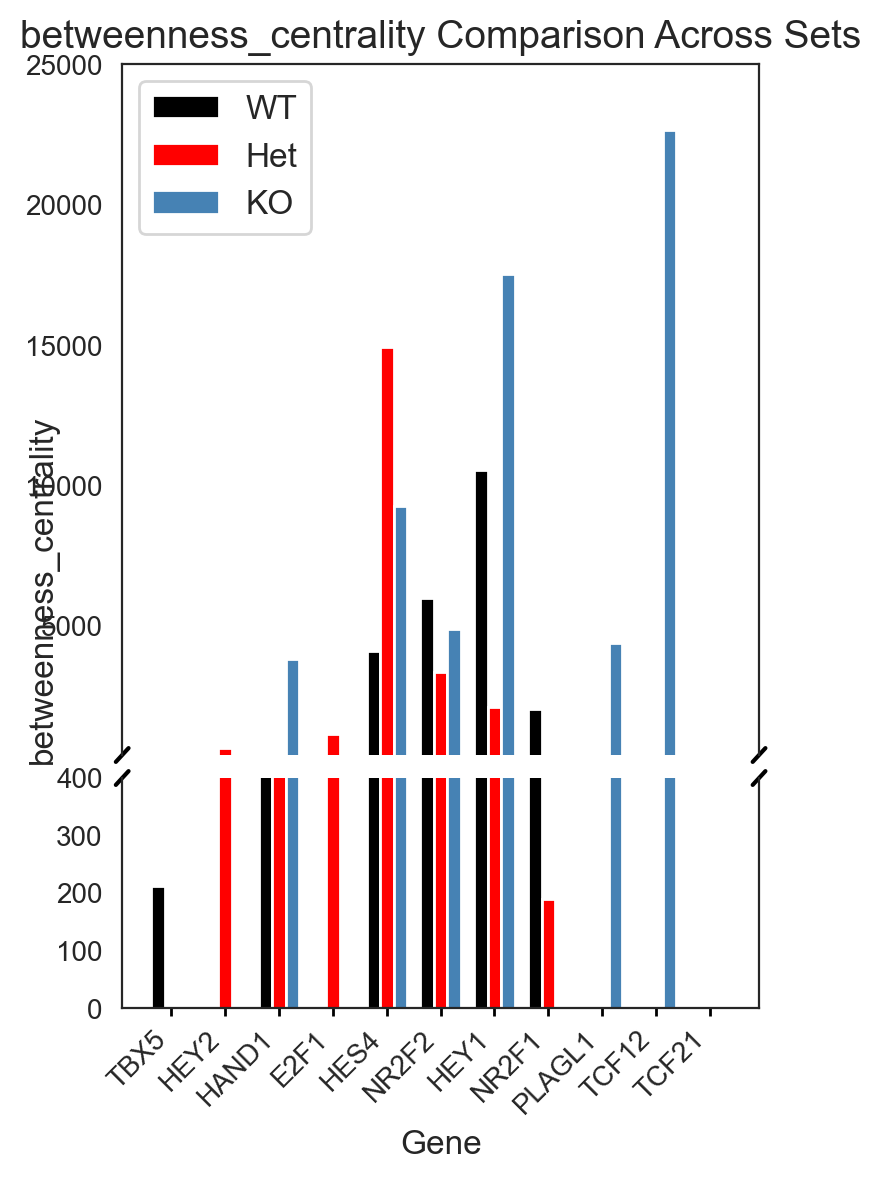

In [39]:
x_positions = range(len(combined.index))
bar_width = 0.25

# Create split bar chart
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 6), gridspec_kw={'height_ratios': [3, 1]})

# Plot top part (50–2000)
ax1.bar([x - bar_width for x in x_positions], combined['WT'], width=bar_width, label='WT', color='black')
ax1.bar(x_positions, combined['Het'], width=bar_width, label='Het', color='red')
ax1.bar([x + bar_width for x in x_positions], combined['KO'], width=bar_width, label='KO', color='steelblue')
if centrality_type == 'degree_out':
    ax1.set_ylim(100, 800)
else:
    ax1.set_ylim(400, 25000)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labeltop=False)

# Plot bottom part (0–50)
ax2.bar([x - bar_width for x in x_positions], combined['WT'], width=bar_width, color='black')
ax2.bar(x_positions, combined['Het'], width=bar_width, color='red')
ax2.bar([x + bar_width for x in x_positions], combined['KO'], width=bar_width, color='steelblue')
if centrality_type == 'degree_out':
    ax2.set_ylim(0, 100)
else:
    ax2.set_ylim(0, 400)
ax2.spines['top'].set_visible(False)

# Diagonal lines to indicate the break
d = .01  # proportion of diagonal cut
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d*3, 1 + d*3), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d*3, 1 + d*3), **kwargs)  # bottom-right diagonal

# Shared labels
ax2.set_xlabel('Gene', fontsize=12)
fig.text(0.04, 0.5, centrality_type, va='center', rotation='vertical', fontsize=12)
ax1.set_title(f'{centrality_type} Comparison Across Sets', fontsize=14)
ax2.set_xticks(x_positions)
ax2.set_xticklabels(combined.index, rotation=45, ha='right', fontsize=10)
ax1.legend(fontsize=12)

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.tick_params(axis='x', direction='out', length=3, width=1, color='black', bottom=True, top=False)


import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# plt.savefig(f'./figures/f-genotype_split_{centrality_type}.pdf', transparent=True)

plt.show()

# Fig 4K, L, M – Wheel Diagrams

In [40]:
genes_for_subnetwork = pd.read_excel("data/genes_for_subnetwork-250316.xlsx", sheet_name=0)

In [41]:
arr = genes_for_subnetwork.chd_af_cent.values
genes_for_wheels = arr[~pd.isna(arr)]

In [43]:
# genes_for_wheels = list(genes_for_wheels)
# genes_for_wheels += ['TBX20', 'TBX5', 'NR2F2', 'PITX2', 'HEY1', 'MEF2C', 'NKX2-5', 'GATA4', 'SRF', 'HAND1', 'IRX4', 'HEY2']
# genes_for_wheels = ['TEAD1', 'TCF21'] # ECM Genes
# genes_for_wheels = ['NKX2-5', 'MEIS2', 'TCF21', 'TCF12', 'TBX5']
genes_for_wheels = ['TBX5', 'NKX2-5', 'TCF12', 'TCF21']

In [44]:
def get_gene_targets(tf, links_wt, links_het, links_ko):
    wt_targets = links_wt[links_wt.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    het_targets = links_het[links_het.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    ko_targets = links_ko[links_ko.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    
    all_targets = list(np.unique(wt_targets.tolist() + het_targets.tolist() + ko_targets.tolist()))
    
    return all_targets

TBX5
Finished TBX5
NKX2-5
Finished NKX2-5
TCF12
Finished TCF12
TCF21
Finished TCF21


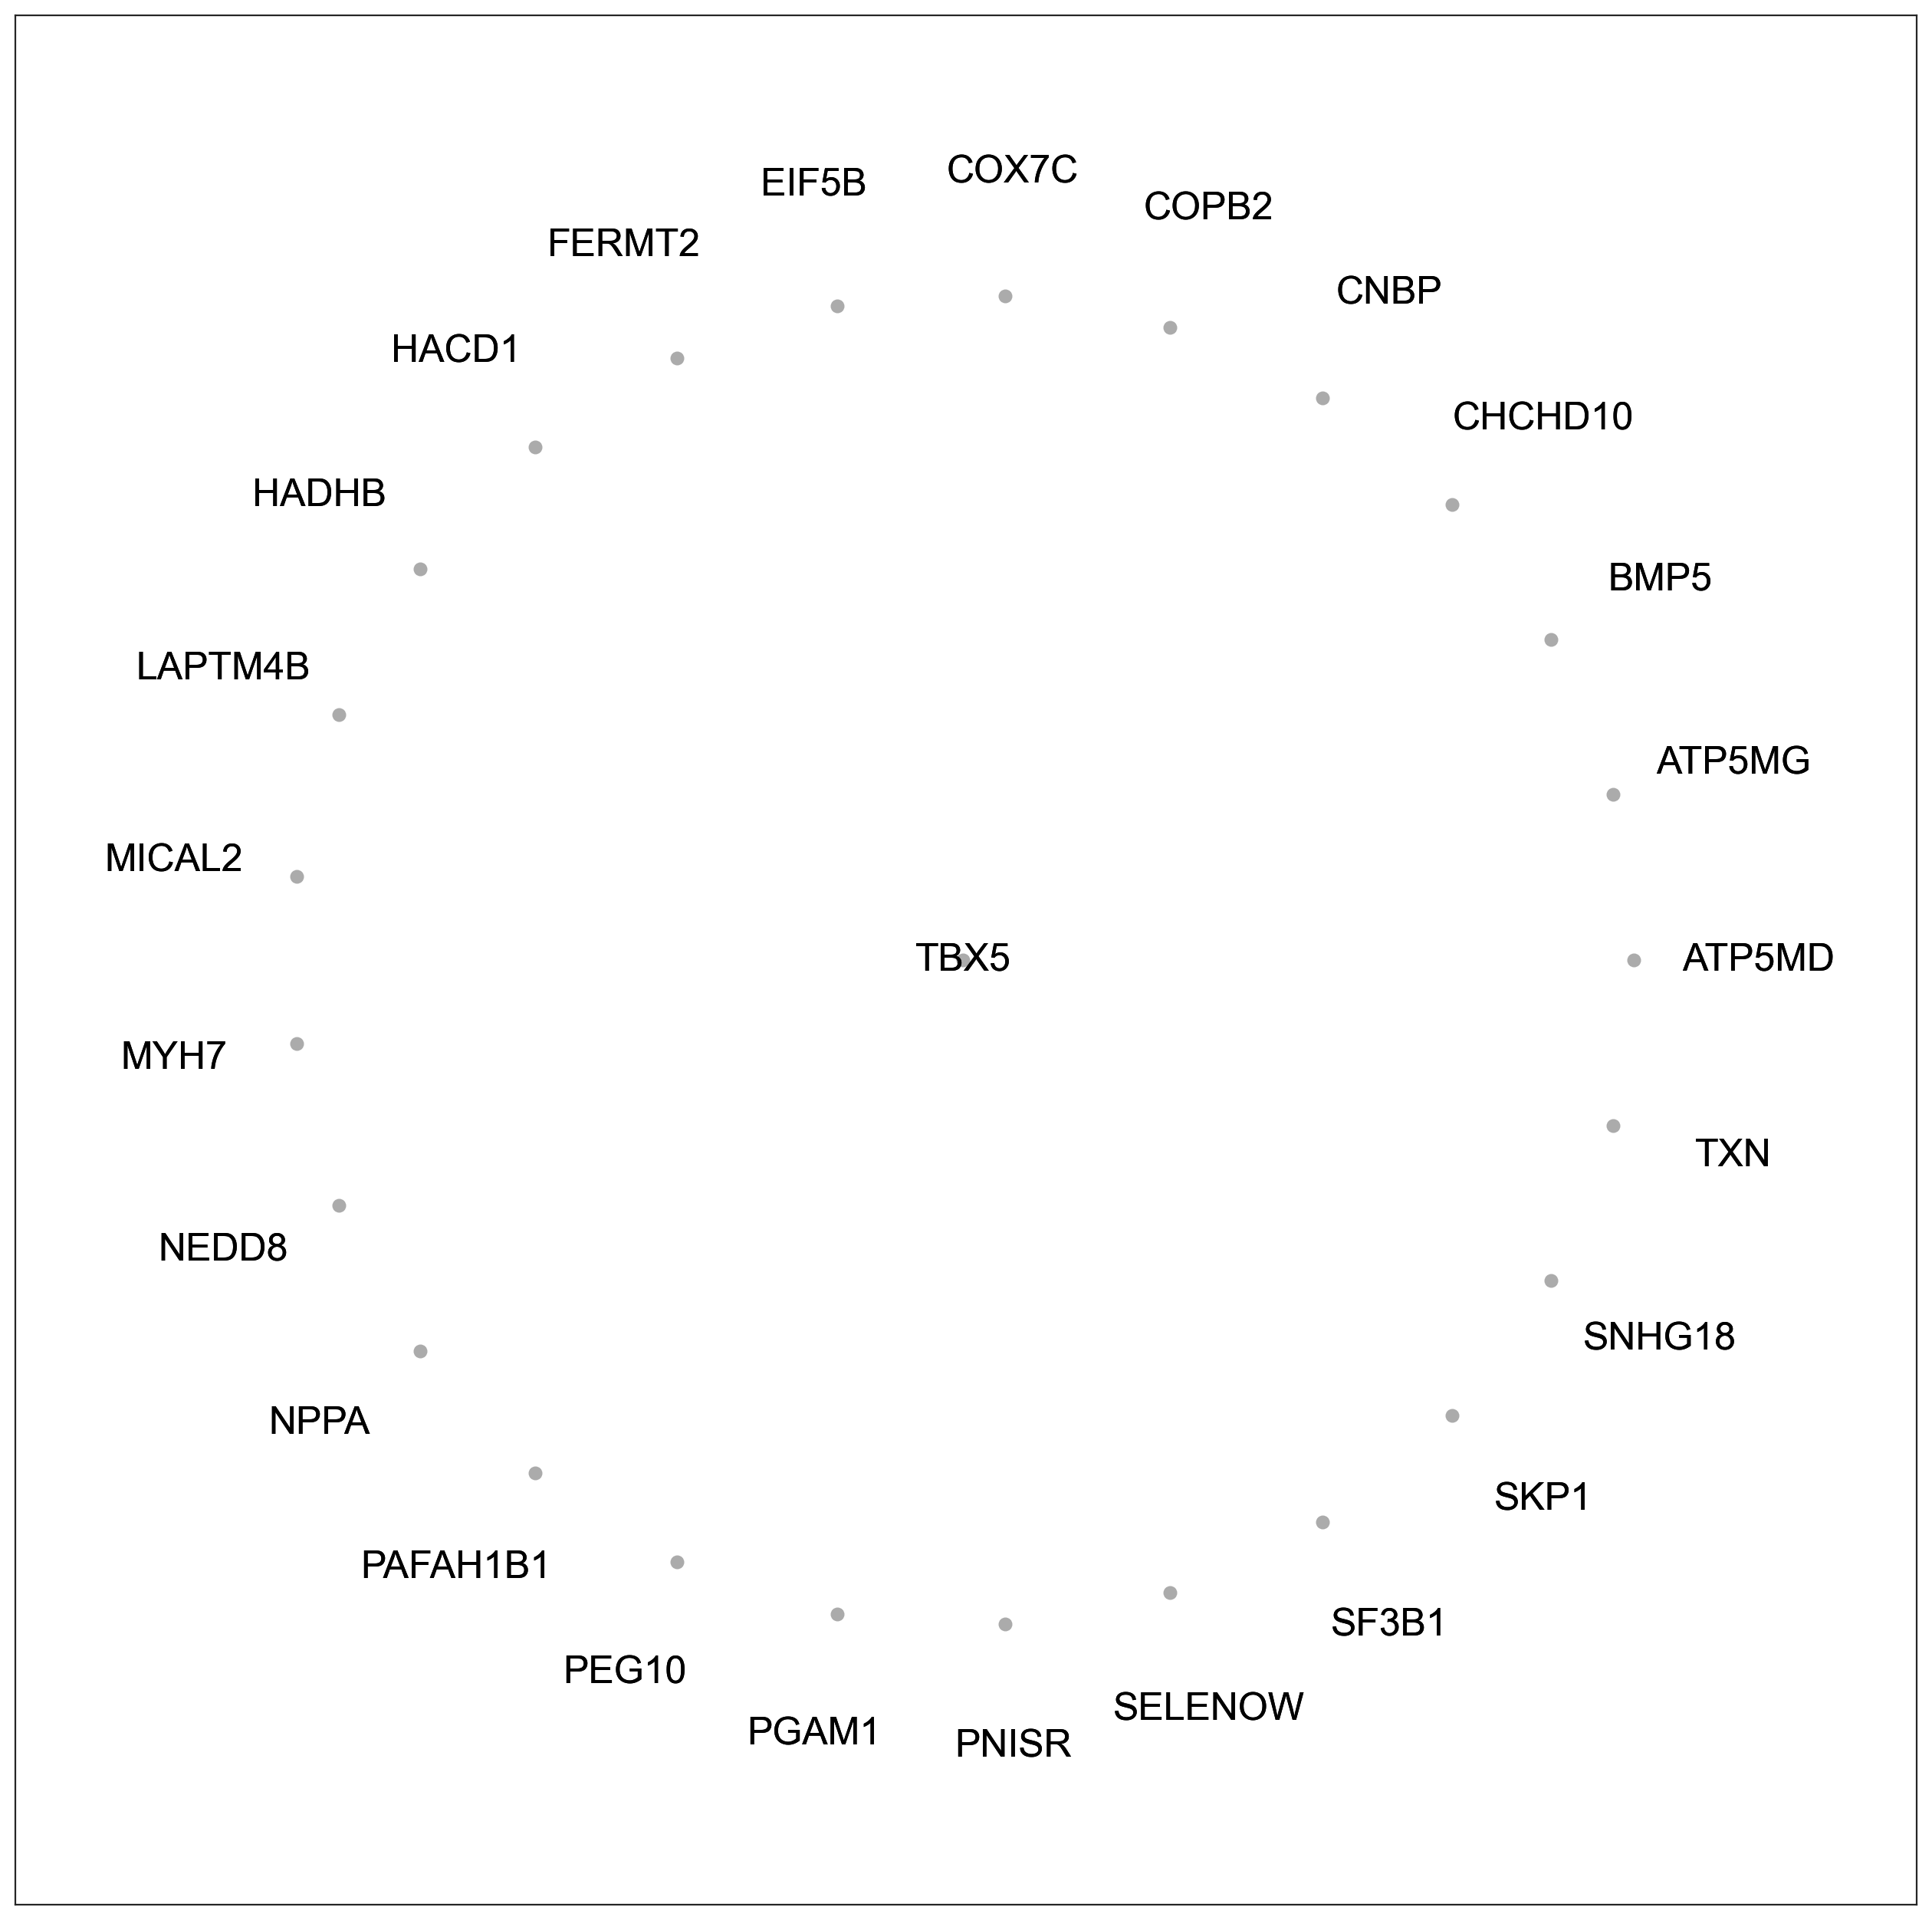

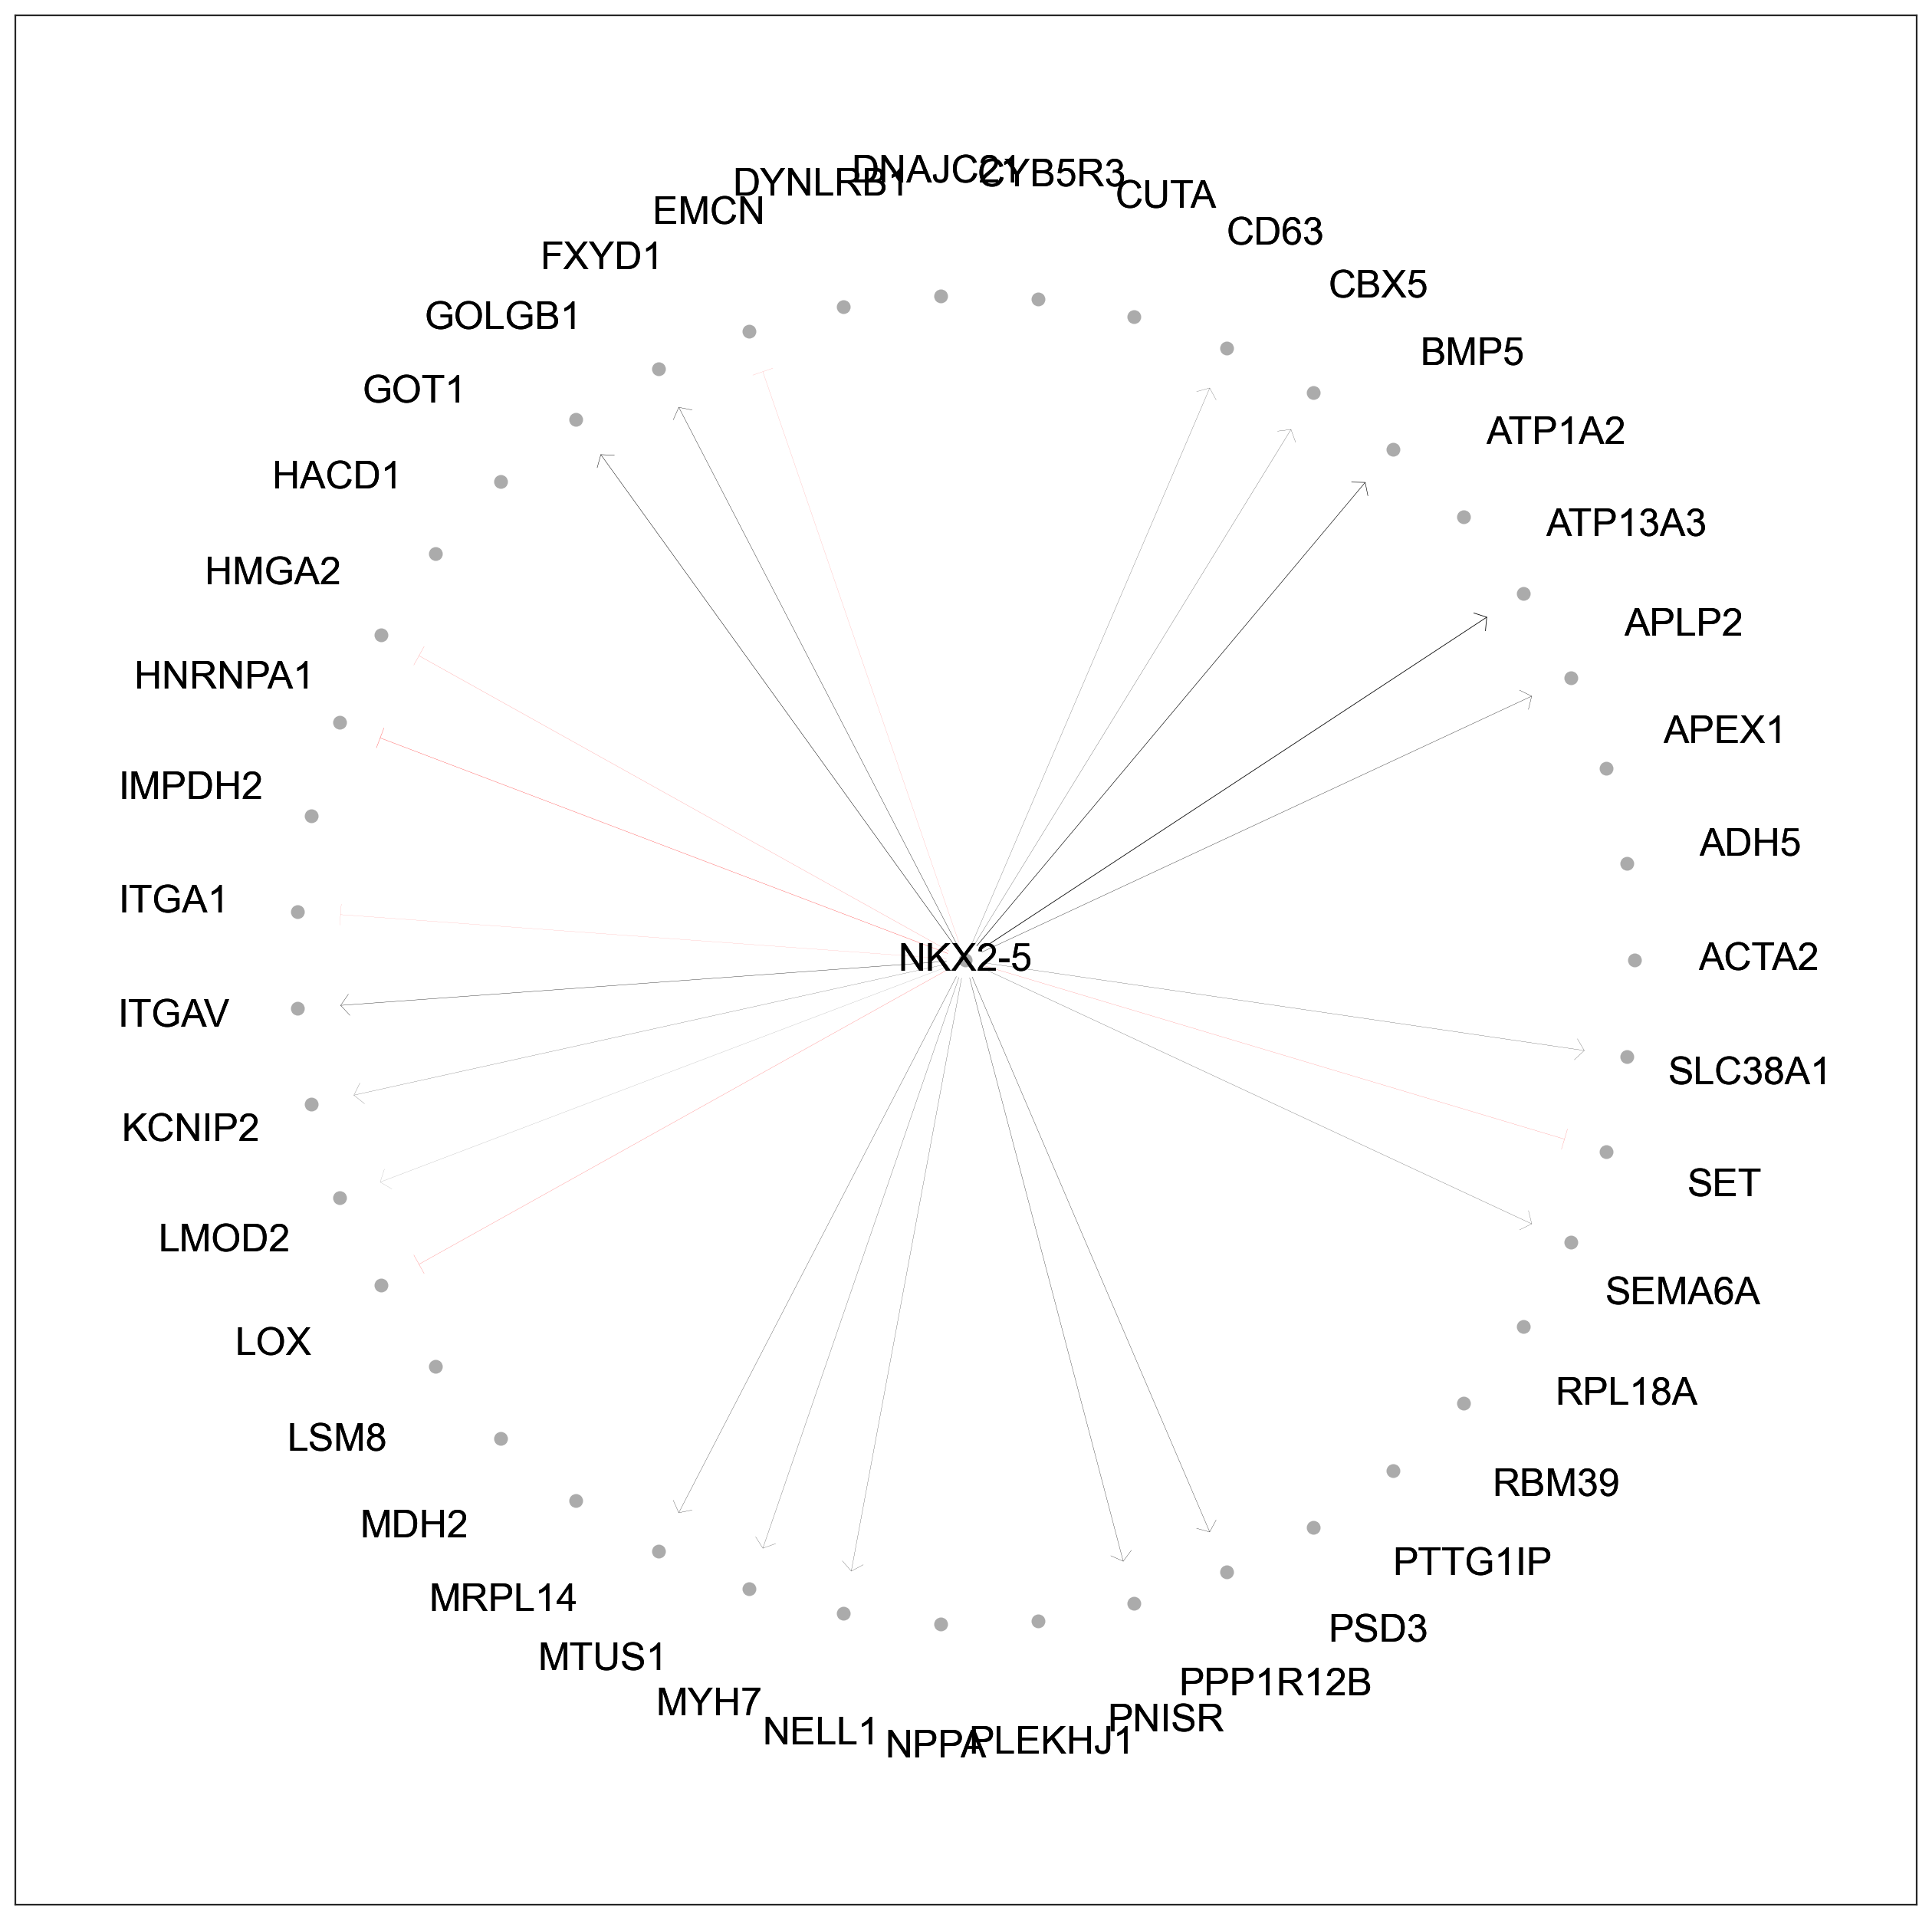

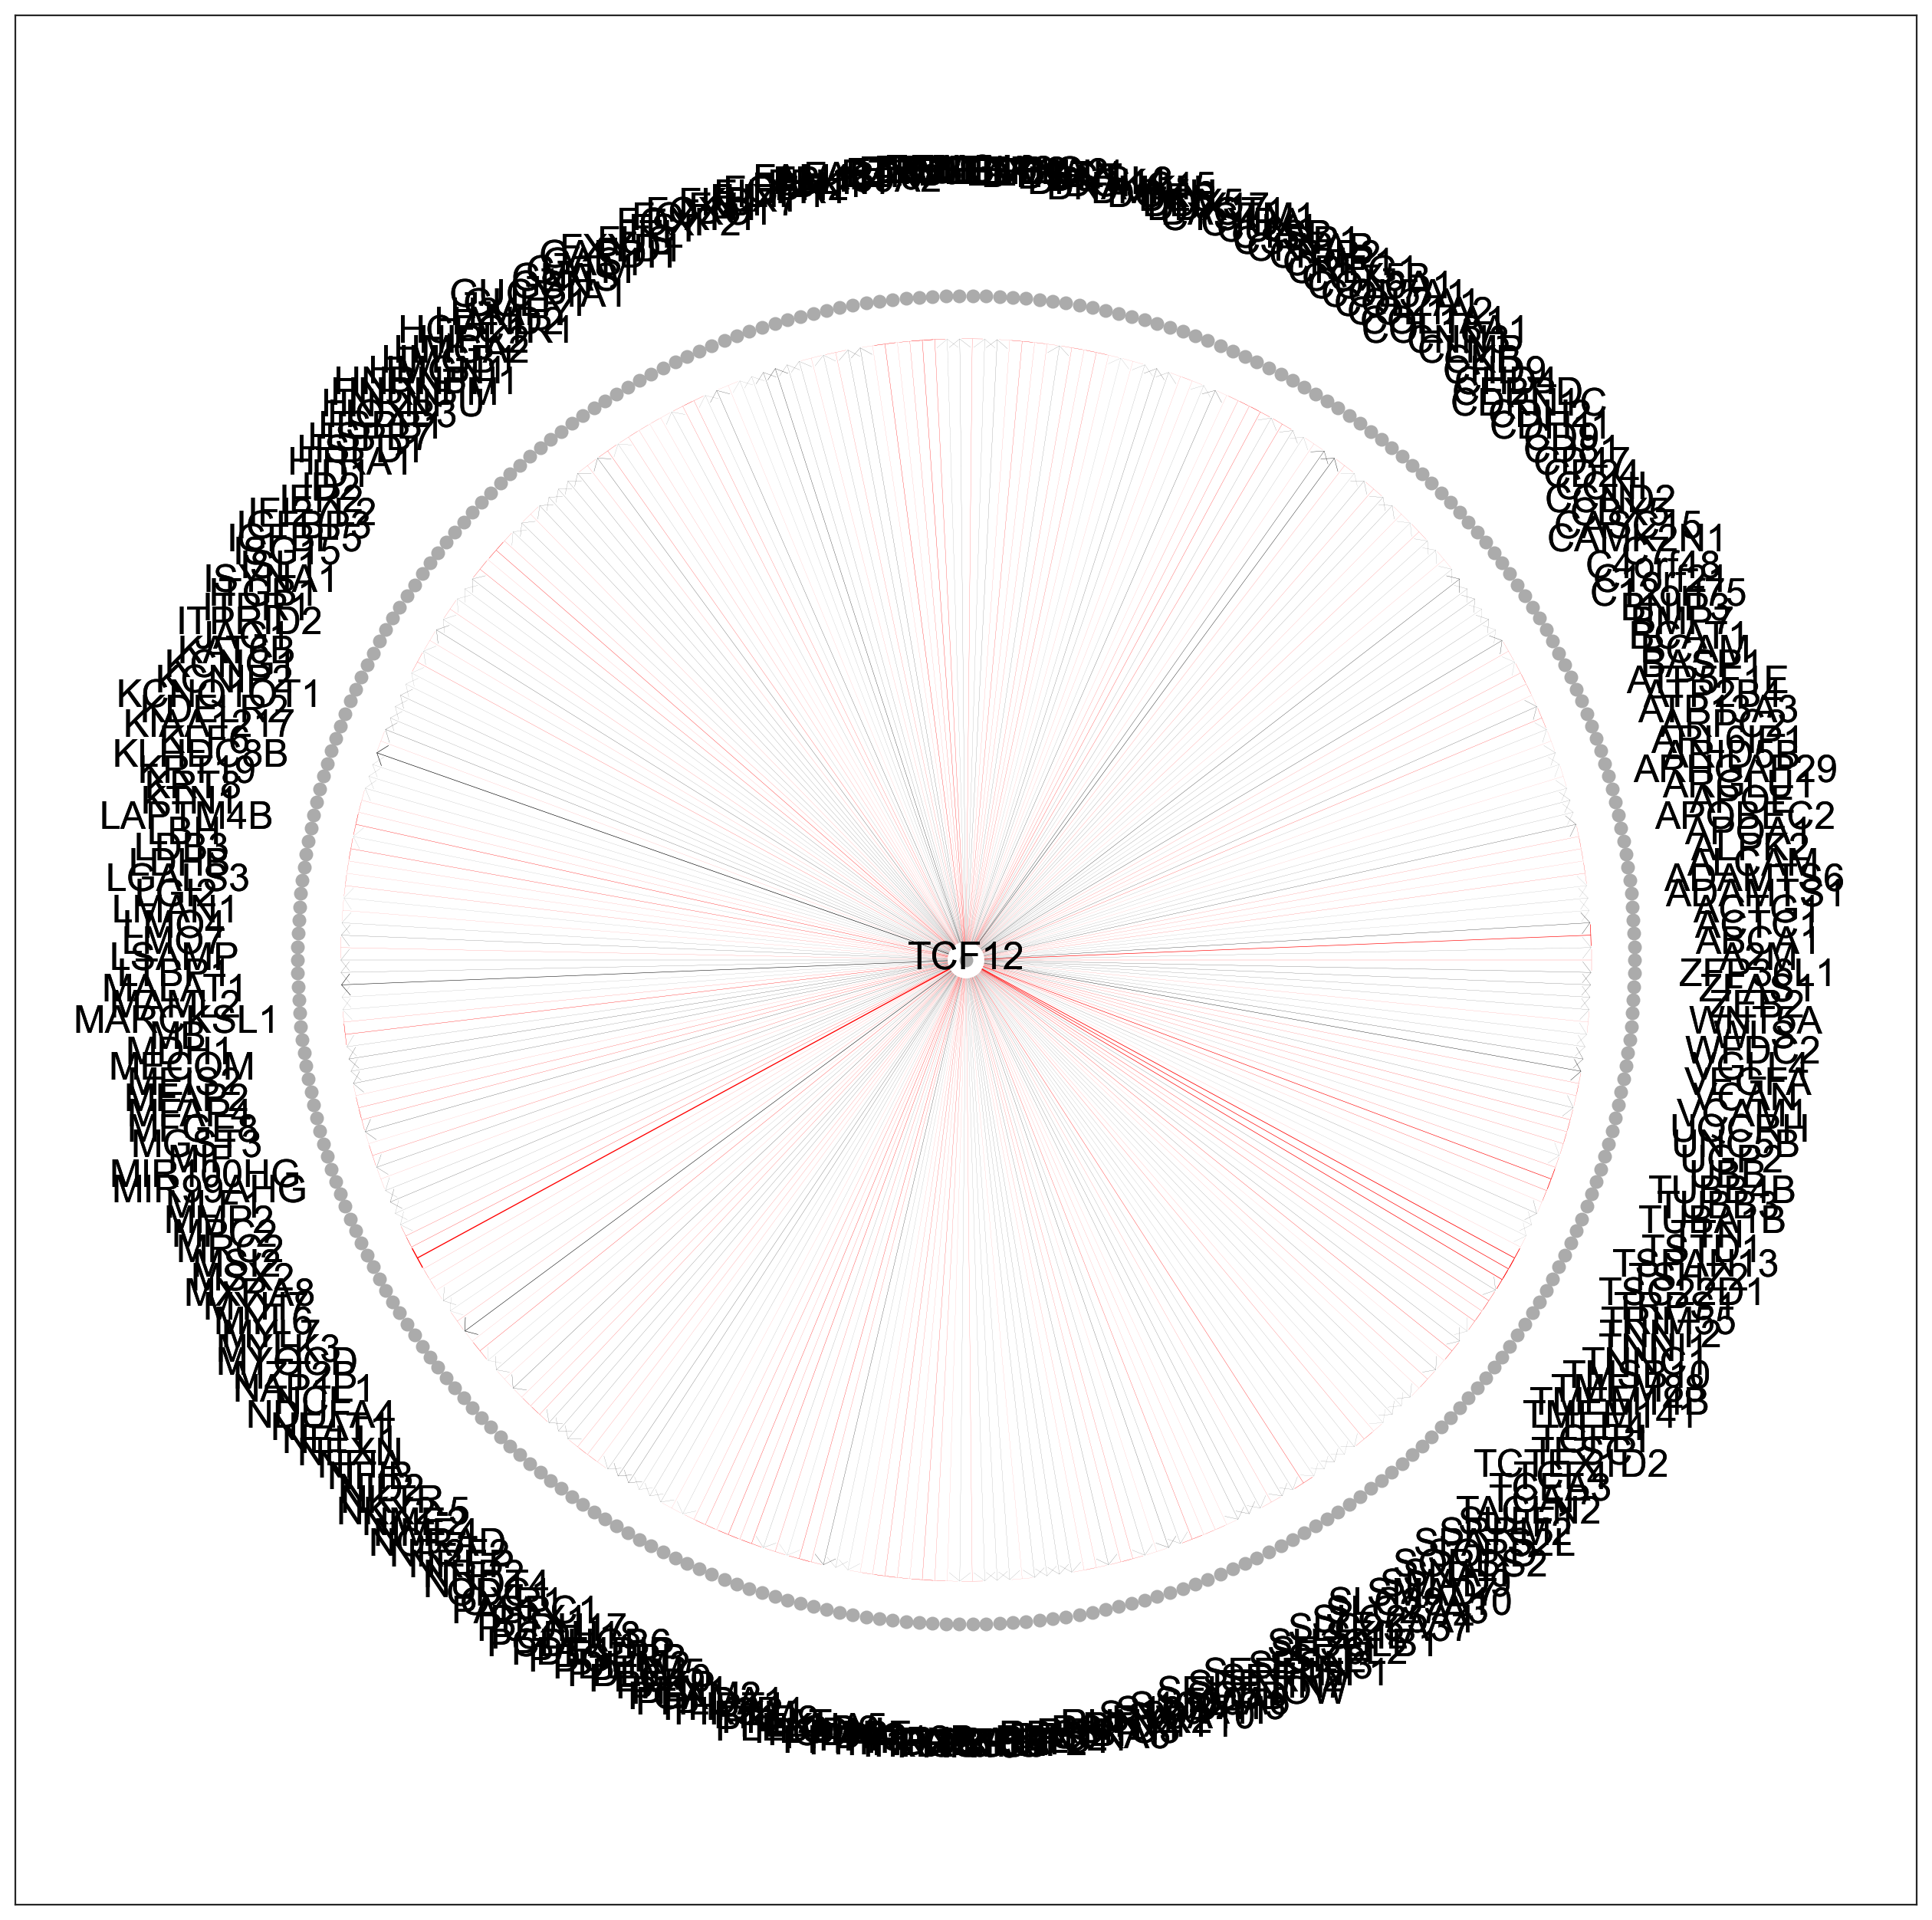

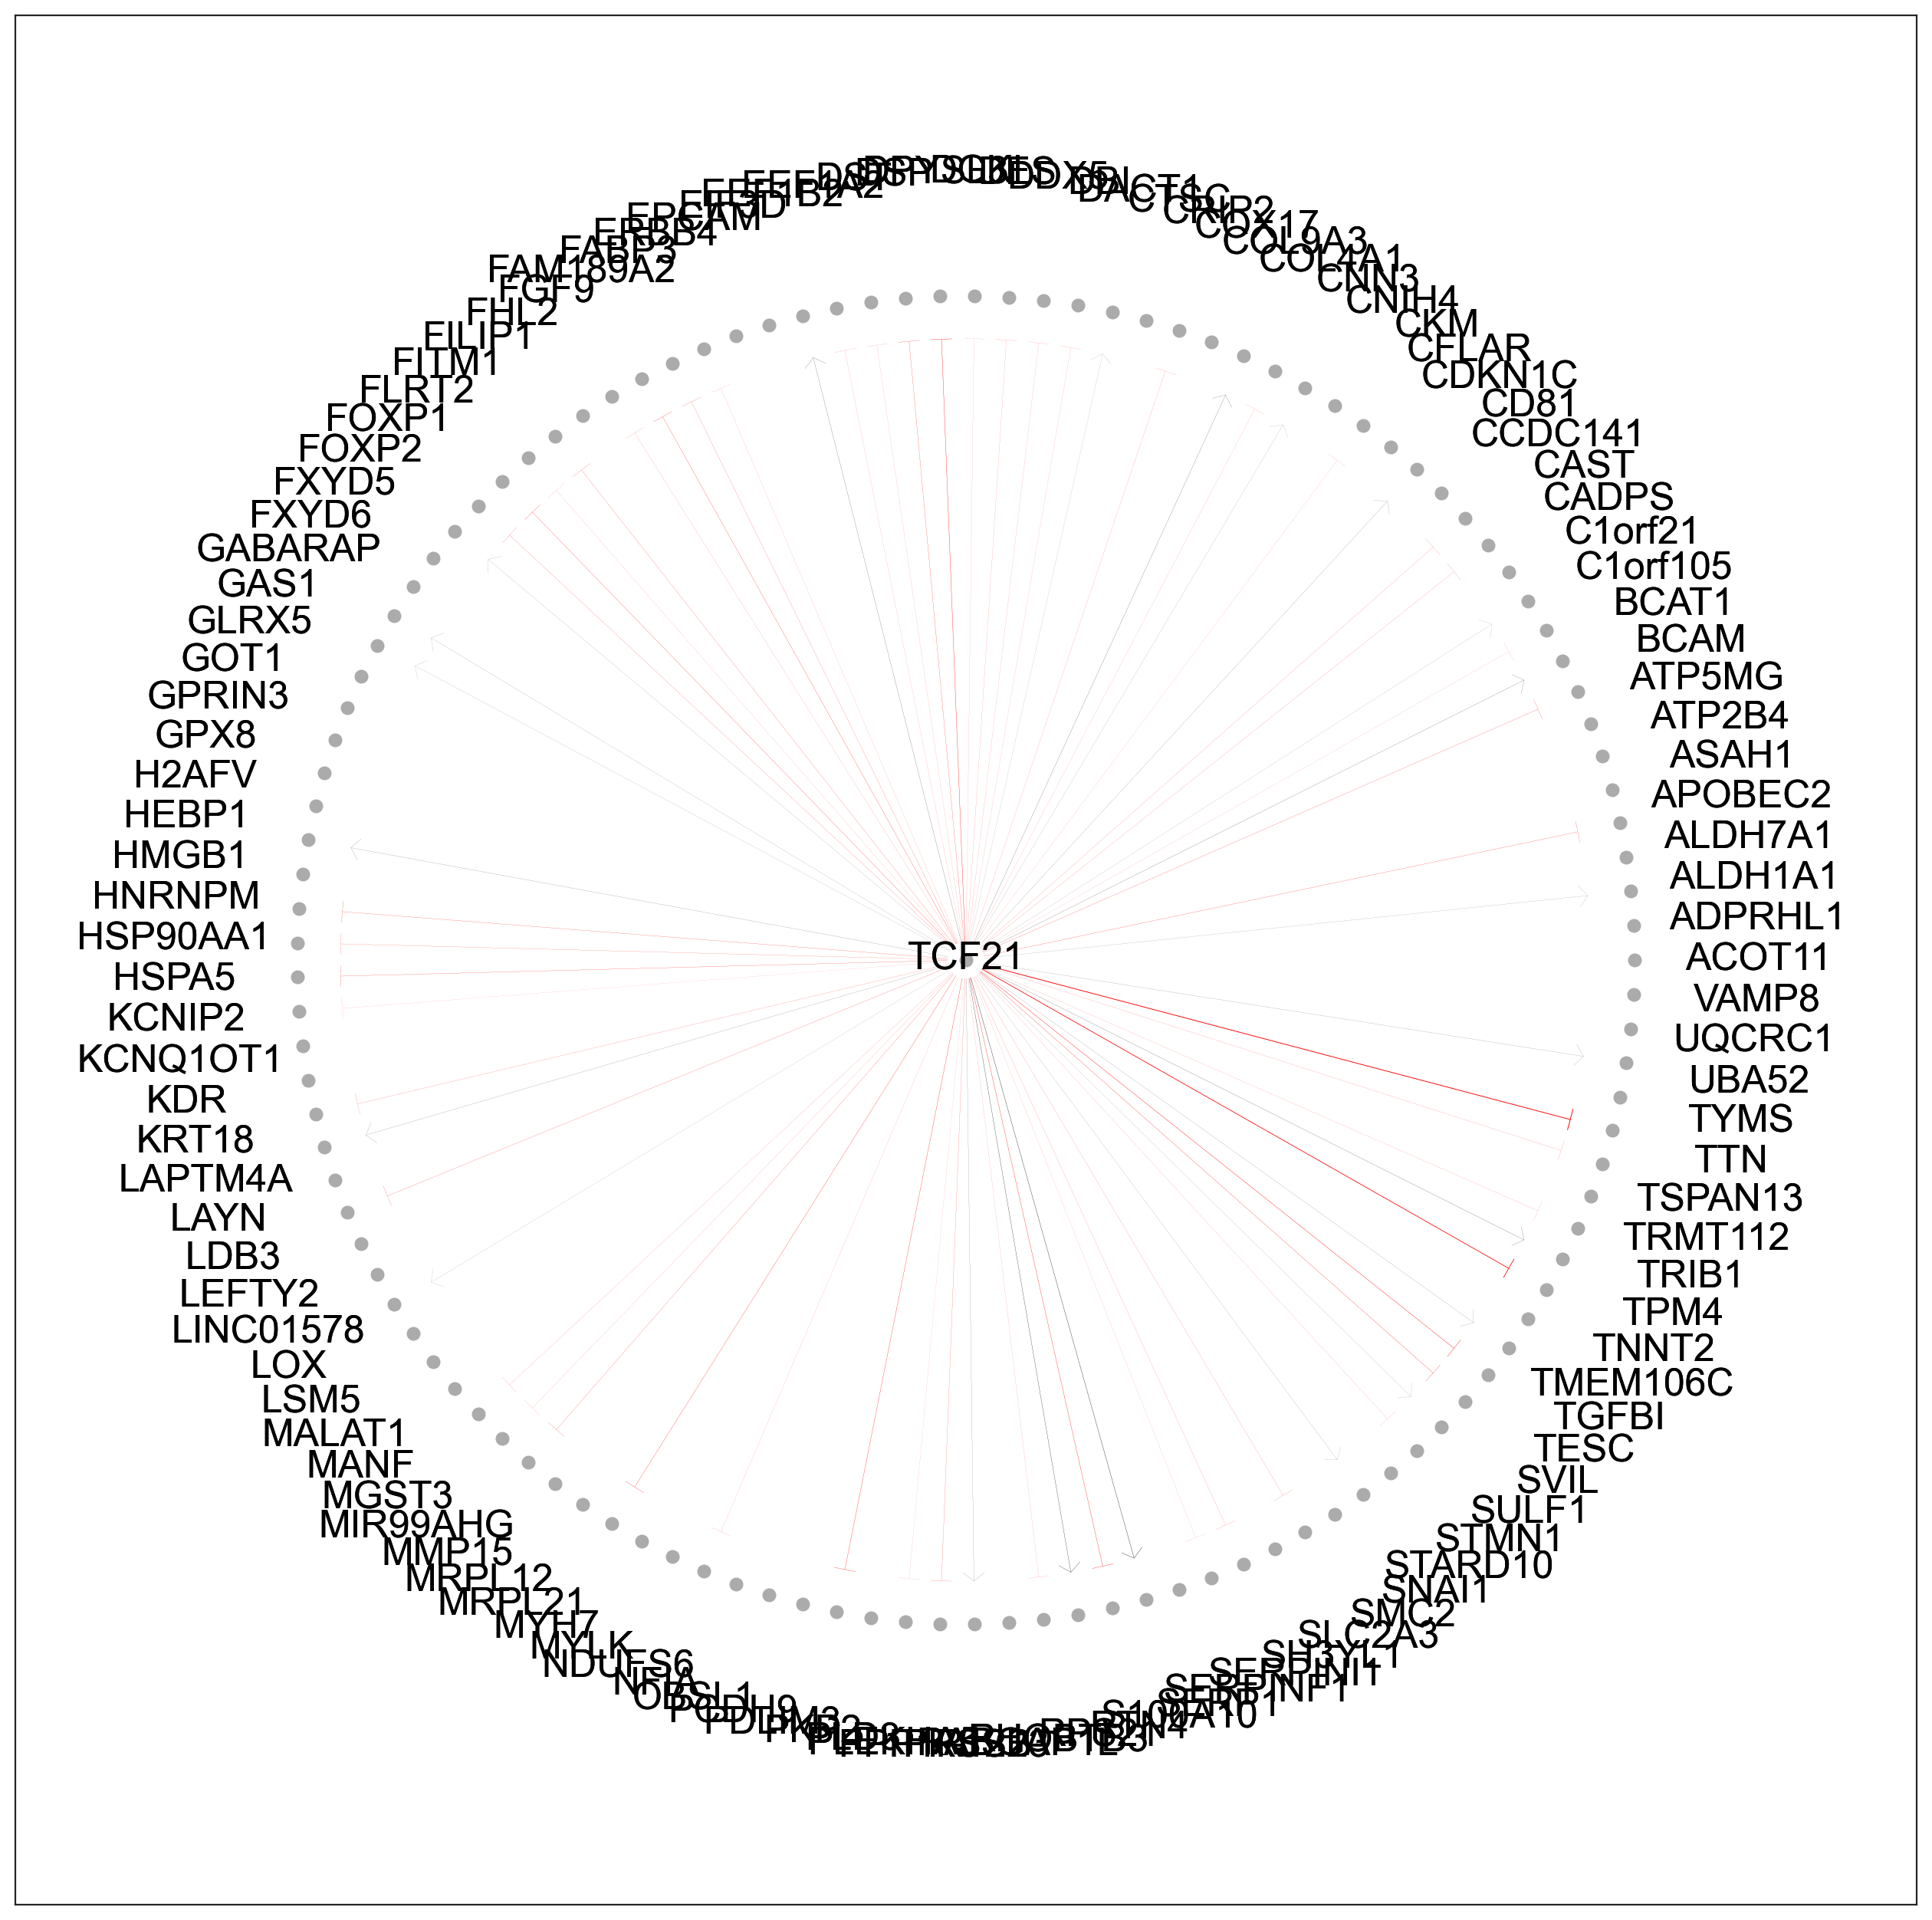

In [49]:
import networkx as nx
import numpy as np
import math
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rc('font', family='Arial')

# Choose between wt, het, or ko
network_class = 'wt'
network_class = 'het'
network_class = 'ko'

for tf in genes_for_wheels:
    if tf in ['HNF4A', 'MYCN', 'TBX20']:
        continue
    links_wt_tmp = links_wt.filtered_links['CMs']
    links_het_tmp = links_het.filtered_links['CMs']
    links_ko_tmp = links_ko.filtered_links['CMs']

    all_targets = get_gene_targets(tf, links_wt_tmp, links_het_tmp, links_ko_tmp)

    fig, ax = plt.subplots(figsize=(16, 16))

    # all_nodes = wt_targets + intersect_targets +  ko_targets
    all_nodes = all_targets

    G_act = nx.DiGraph()
    G_act.add_nodes_from(all_nodes)
    G_inhib = nx.DiGraph()
    G_inhib.add_nodes_from(all_nodes)

    pos = nx.circular_layout(G_act.subgraph(all_nodes))

    G_act.add_node(tf)
    G_inhib.add_node(tf)

    if network_class == 'wt':
        tf_links = links_wt_tmp[links_wt_tmp.source == tf]
    elif network_class == 'het':
        tf_links = links_het_tmp[links_het_tmp.source == tf]
    else:
        tf_links = links_ko_tmp[links_ko_tmp.source == tf]

    for x in tf_links.target:
        connection = tf_links[tf_links.target == x]
        if connection.coef_mean.values[0] < 0:
            G_inhib.add_edge(tf, x, weight=connection.coef_abs.values[0]*40, color='red')
        else:
            G_act.add_edge(tf, x, weight=connection.coef_abs.values[0]*40, color='black')


    for i, G in enumerate([G_act, G_inhib]):
        edges = G.edges()
        colors = [G[u][v]['color'] for u,v in edges]
        weights = [G[u][v]['weight']*1.5 for u,v in edges]
        center_node = tf
        pos[center_node] = np.array([0, 0])

        try:
            pos_higher = nx.rescale_layout_dict(pos, 16)
        except:
            continue
        nx.draw_networkx_labels(G, pos_higher, font_size=18)

        pos_lower = nx.rescale_layout_dict(pos, 13)
        # nx.draw_networkx_nodes(G, pos, node_color="#005D32")

        if i == 0:
            nx.draw_networkx_edges(G, pos_lower, width=weights, edge_color=colors, arrows=True, arrowstyle=matplotlib.patches.ArrowStyle('->', head_length=0.4, head_width=0.5))
        else:

            nx.draw_networkx_edges(G, pos_lower, width=weights, edge_color=colors, arrows=True, arrowstyle=matplotlib.patches.ArrowStyle('|-|', widthA=0, angleA=0, widthB=.5, angleB=0))
           
    print(tf)
    pos_mid = nx.rescale_layout_dict(pos, 13.5)
    
    nx.draw_networkx_nodes(G, pos_mid, node_color="#ababab", node_size=30)

    x_values, y_values = zip(*pos_higher.values())
    x_max = max(x_values)
    x_min = min(x_values)
    x_margin = (x_max - x_min) * 0.1
    plt.xlim(float(x_min - x_margin), float(x_max + x_margin))

    y_max = max(y_values)
    y_min = min(y_values)
    y_margin = (y_max - y_min) * 0.1
    plt.ylim(float(y_min - y_margin), float(y_max + y_margin))
    plt.savefig(f"./data/wheel-diagrams/{tf}-{network_class}.pdf", format='pdf')
    print(f'Finished {tf}')